<a href="https://colab.research.google.com/github/Kenicki/Kenicki/blob/main/Diabetes_mlops_decision_tree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import wandb
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import tempfile
import os
%matplotlib inline

Get the data

In [24]:
# import dataset
df= pd.read_csv('/content/diabetes.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [25]:

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [26]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [13]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


In [15]:
#checking for duplicates
df.duplicated().sum()

np.int64(0)

In [17]:
# Outcome vs pregnancies?
pd.crosstab(df.Outcome,df.Pregnancies,margins=True,normalize=True)

Pregnancies,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,17,All
Outcome,,,,,,,,,,,,,,,,,,
0,0.095052,0.138021,0.109375,0.062500,0.058594,0.046875,0.044271,0.026042,0.020833,0.013021,0.018229,0.005208,0.006510,0.006510,0.000000,0.000000,0.000000,0.651042
1,0.049479,0.037760,0.024740,0.035156,0.029948,0.027344,0.020833,0.032552,0.028646,0.023438,0.013021,0.009115,0.005208,0.006510,0.002604,0.001302,0.001302,0.348958
All,0.144531,0.175781,0.134115,0.097656,0.088542,0.074219,0.065104,0.058594,0.049479,0.036458,0.031250,0.014323,0.011719,0.013021,0.002604,0.001302,0.001302,1.000000


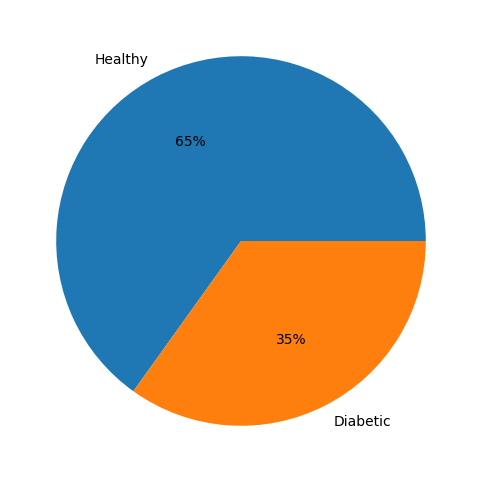

In [18]:
# check if data is balanced?
plt.figure(figsize=(6,6))
labels = ['Healthy','Diabetic']
values = [df.Outcome.value_counts()[0], df.Outcome.value_counts()[1]]
plt.pie(values, labels=labels,autopct = '%0.0f%%')
plt.show()

<Axes: >

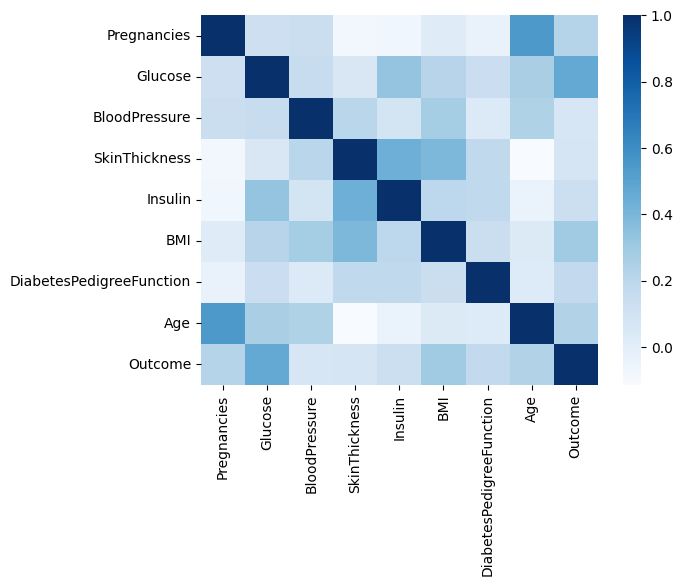

In [19]:

# Correlation theough a heatmap
sns.heatmap(df.corr(),cmap='Blues',annot=False)

<Axes: >

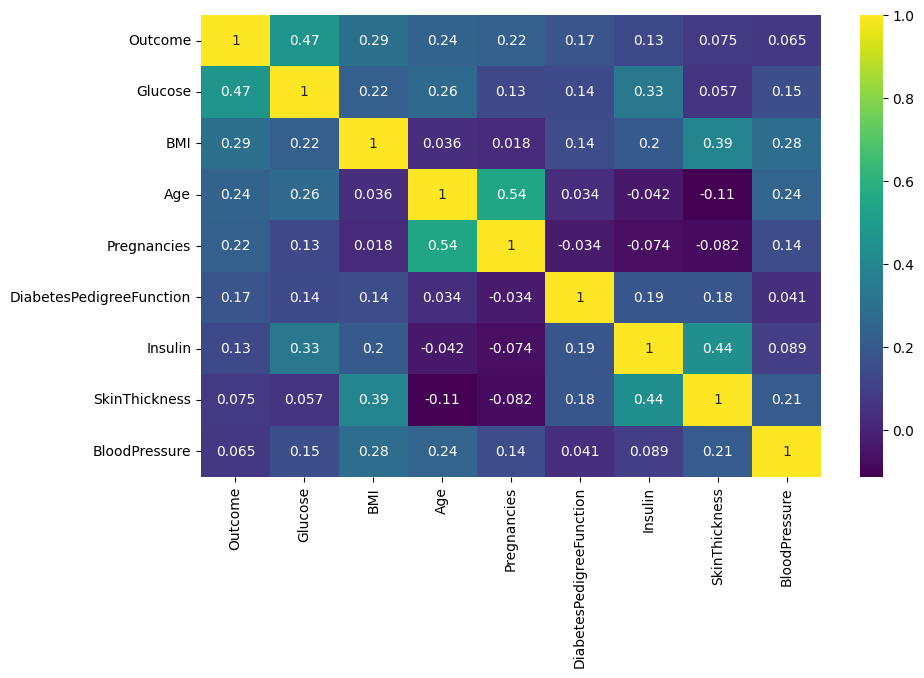

In [20]:

#Outcome correlation matrix
k = 9 #number of variables for heatmap
cols = df.corr().nlargest(k, 'Outcome')['Outcome'].index
cm = df[cols].corr()
plt.figure(figsize=(10,6))
sns.heatmap(cm, annot=True, cmap = 'viridis')

NameError: name 'run' is not defined

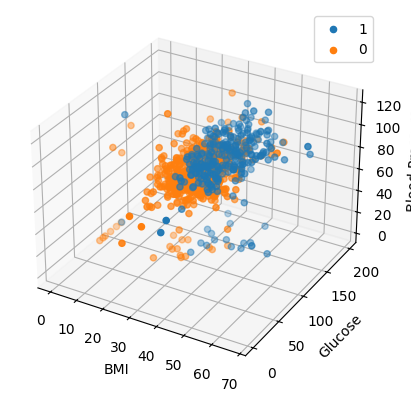

In [23]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for s in df.Outcome.unique():
    ax.scatter(df.BMI[df.Outcome==s],df.Glucose[df.Outcome==s],df.BloodPressure[df.Outcome==s],label=s)
ax.legend()
ax.set_xlabel('BMI')
ax.set_ylabel('Glucose')
ax.set_zlabel('Blood Pressure')

ax.figure.savefig('BMIxGlucosexBloodPressure.png')
run.log(
        {
            "BMIxGlucosexBloodPressure": wandb.Image("BMIxGlucosexBloodPressure.png")
        }
        )